# <span style="color:#0b486b">  FIT3181/5215: Deep Learning (2025)</span>
***
*CE/Lecturer (Clayton):*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Lecturer (Clayton):* **A/Prof Zongyuan Ge** | zongyuan.ge@monash.edu <br/>
*Lecturer (Malaysia):*  **Dr Arghya Pal** | arghya.pal@monash.edu <br/>
 <br/>
*Head Tutor 3181:*  **Ms Ruda Nie H** |  \[RudaNie.H@monash.edu \] <br/>
*Head Tutor 5215:*  **Ms Leila Mahmoodi** |  \[leila.mahmoodi@monash.edu \]

<br/> <br/>
Faculty of Information Technology, Monash University, Australia
***

# <span style="color:#0b486b">Tutorial 06b: Attack and Defence Deep Learning Models</span>  <span style="color:red">*****</span> #
This is a **have-to-learn** knowledge because this would appear in the exam or assignment of this unit.

**Deep learning models even the SOTA ones are fragile and easy to be attacked by adversarial examples. This tutorial focuses on how to run attacks to fool deep learning models and how to train more secure and safe deep learning models using adversarial training:**

I. Adversarial attacks including FGSM, PGD and TRADES.

II. Train more secure and robust models using adversarial training.

**References and additional reading and resources**
- Adversarial machine learning tutorial ([link](https://adversarial-ml-tutorial.org/introduction/)).
- Adversarial example using FGSM tutorial ([link](https://www.tensorflow.org/tutorials/generative/adversarial_fgsm)).
---


### <span style="color:#0b486b"> II.0 Running on Google Colab</span> <span style="color:red"></span>
To run this notebook on Google Colab, ensure you download the necessary files.

In [ ]:
!gdown https://drive.google.com/uc?id=1CAB701DGytYby9tE4nHkEMQV8yWlHJ9Q

Downloading...
From: https://drive.google.com/uc?id=1CAB701DGytYby9tE4nHkEMQV8yWlHJ9Q
To: /content/Tut06_data.zip
100% 335k/335k [00:00<00:00, 4.81MB/s]


In [ ]:
!unzip -q Tut06_data.zip

## <span style="color:#0b486b">I. Define attack functions </span> ##

We first manually implement the popular adversarial attacks including FGSM, PGD, MIM, and TRADES ones. Those attacks have also been implemented in [CleverHans](https://github.com/cleverhans-lab/cleverhans), a library for adversarial machine learning in which many adversarial attacks are implemented. Subsequently, we can use those adversarial examples crafted from those attacks to strengthen the adversarial robustness of DL models for obtaining more robust and secure DL models.

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We first implement Fast Gradient Sign Method (FGSM) in this paper: https://arxiv.org/pdf/1412.6572.pdf.

In [ ]:
def fgsm_attack(model, input_image, input_label=None,
                epsilon=0.3,
                clip_value_min=0.,
                clip_value_max=1.0):
    """
    Args:
        model: pretrained model
        input_image: original (clean) input image (tensor)
        input_label: original label (tensor, categorical representation)
        epsilon: perturbation boundary
        clip_value_min, clip_value_max: range of valid input
        from_logits = True: attack from logits otherwise attack from prediction probabilities
    Note:
        we expect the output of model should be logits vector
    """

    if type(input_image) is np.ndarray:
        input_image = torch.tensor(input_image, requires_grad=True)

    if type(input_label) is np.ndarray:
        input_label = torch.tensor(input_label)

    # Ensure the model is in evaluation mode
    model.eval()

    # Create a copy of the input image and set it to require gradients
    adv_image = input_image.clone().detach().requires_grad_(True)  # Ensure requires_grad is True

    # Random initialization around input_image
    random_noise = torch.FloatTensor(input_image.shape).uniform_(-epsilon, epsilon).to(device)
    adv_image = adv_image + random_noise
    adv_image = torch.clamp(adv_image, clip_value_min, clip_value_max).detach().requires_grad_(True)

    output = model(adv_image)

    if input_label is not None:
        loss = F.cross_entropy(output, input_label)  # use ground-truth label to attack
    else:
        pred_label = output.argmax(dim=1)  # use predicted label to attack
        loss = F.cross_entropy(output, pred_label)

    model.zero_grad()
    loss.backward()
    gradient = input_image.grad.data
    adv_image = input_image + epsilon * gradient.sign()
    adv_image = torch.clamp(adv_image, clip_value_min, clip_value_max)

    return adv_image.detach()

# Example usage:
# model = models.vgg19(pretrained=True)
# input_image = torch.rand(1, 3, 224, 224)  # Example image tensor
# input_label = torch.tensor([0])  # Example label tensor
# adv_image = fgsm_attack(model, input_image, input_label)


We now implement  Projected Gradient Descend (PGD) proposed in this paper: https://openreview.net/pdf?id=rJzIBfZAb. PGD can be viewed as an extended version of FGSM in which we attack in many iterations.

In [ ]:
def pgd_attack(model, input_image, input_label=None,
               epsilon=0.3,
               num_steps=20,
               step_size=0.01,
               clip_value_min=0.,
               clip_value_max=1.0):

    if type(input_image) is np.ndarray:
        input_image = torch.tensor(input_image, requires_grad=True)

    if type(input_label) is np.ndarray:
        input_label = torch.tensor(input_label)

    # Ensure the model is in evaluation mode
    model.eval()

    # Create a copy of the input image and set it to require gradients
    adv_image = input_image.clone().detach().requires_grad_(True)  # Ensure requires_grad is True

    # Random initialization around input_image
    random_noise = torch.FloatTensor(input_image.shape).uniform_(-epsilon, epsilon).to(device)
    adv_image = adv_image + random_noise
    adv_image = torch.clamp(adv_image, clip_value_min, clip_value_max).detach().requires_grad_(True)

    # If no input label is provided, use the model's prediction
    if input_label is None:
        output = model(input_image)
        input_label = torch.argmax(output, dim=1)

    # Perform PGD attack
    for _ in range(num_steps):
        adv_image.requires_grad_(True)  # Ensure requires_grad is True in each iteration
        output = model(adv_image)
        loss = nn.CrossEntropyLoss()(output, input_label)
        model.zero_grad()
        loss.backward()

        # Check if gradient is available before accessing 'data'
        if adv_image.grad is not None:
            gradient = adv_image.grad.data
            adv_image = adv_image + step_size * gradient.sign()
            adv_image = torch.clamp(adv_image, input_image - epsilon, input_image + epsilon)  # Clip to a valid boundary
            adv_image = torch.clamp(adv_image, clip_value_min, clip_value_max)  # Clip to a valid range
            adv_image = adv_image.detach()  # Detach to prevent gradient accumulation
        else:
            print("Warning: Gradient is None. Check for detach operations.")

    return adv_image.detach()


Finally, we implement one of the most famous approaches for attack and defence TRADES proposed in this paper: http://proceedings.mlr.press/v97/zhang19p/zhang19p.pdf.

In [ ]:
def trades_attack(model, input_image, input_label = None,
                  epsilon=0.3,
                  num_steps=20,
                  step_size=0.01,
                  clip_value_min=0.,
                  clip_value_max=1.0):
    """
    Args:
        model: pretrained model
        input_image: original (clean) input image (tensor)
        input_label: original label (tensor, categorical representation)
        epsilon: perturbation boundary
        num_steps: number of attack steps
        step_size: size of each move in each attack step
        clip_value_min, clip_value_max: range of valid input
    Note:
        we expect the output of model should be logits vector
    """

    if isinstance(input_image, np.ndarray):
        input_image = torch.tensor(input_image, requires_grad=True)
    if isinstance(input_label, np.ndarray):
        input_label = torch.tensor(input_label)

    # Ensure the model is in evaluation mode
    model.eval()

    # Create a copy of the input image and set it to require gradients
    adv_image = input_image.clone().detach().requires_grad_(True)  # Ensure requires_grad is True

    # Random initialization around input_image
    random_noise = torch.FloatTensor(input_image.shape).uniform_(-epsilon, epsilon).to(device)
    adv_image = adv_image + random_noise
    adv_image = torch.clamp(adv_image, clip_value_min, clip_value_max).detach().requires_grad_(True)


    nat_output = model(input_image).detach()
    nat_prediction = F.softmax(nat_output, dim=1)


    for _ in range(num_steps):
        adv_image.requires_grad_(True)
        adv_output = model(adv_image)
        adv_prediction = F.softmax(adv_output, dim=1)
        loss = F.kl_div(F.log_softmax(adv_prediction, dim=1), nat_prediction, reduction='batchmean')

        model.zero_grad()
        loss.backward()
        gradient = adv_image.grad.data
        adv_image = adv_image + step_size * gradient.sign()
        adv_image = torch.clamp(adv_image, input_image - epsilon, input_image + epsilon)  # Clip to a valid boundary
        adv_image = torch.clamp(adv_image, clip_value_min, clip_value_max)  # Clip to a valid range
        adv_image = adv_image.detach()  # Detach to prevent gradient accumulation

    return adv_image.detach()  # Detach to stop the gradient

# Example usage:
# model = models.vgg19(pretrained=True)
# input_image = torch.rand(1, 3, 224, 224)  # Example image tensor
# input_label = torch.tensor([0])  # Example label tensor
# adv_image = trades_attack(model, input_image, input_label)

Warp different type of attack in to one function for convinience

In [ ]:
def attack(attack_type, model, input_image,
            input_label=None,
            epsilon=0.3,
            num_steps=20,
            step_size=0.01,
            clip_value_min=0.,
            clip_value_max=1.0):

    if attack_type == 'fgsm':
        return fgsm_attack(model=model,
                        input_image=input_image,
                        input_label=input_label,
                        epsilon=epsilon,
                        clip_value_min=clip_value_min,
                        clip_value_max=clip_value_max)

    elif attack_type == 'trades':
        return trades_attack(model=model,
                            input_image=input_image,
                            input_label=input_label,
                            epsilon=epsilon,
                            num_steps=num_steps,
                            step_size=step_size,
                            clip_value_min=clip_value_min,
                            clip_value_max=clip_value_max)
    else:
        return pgd_attack(model=model,
                        input_image=input_image,
                        input_label=input_label,
                        epsilon=epsilon,
                        num_steps=num_steps,
                        step_size=step_size,
                        clip_value_min=clip_value_min,
                        clip_value_max=clip_value_max)


## <span style="color:#0b486b">II. Attack SOTA pretrained model</span> ##

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import math
from PIL import Image
import numpy as np

In [ ]:
# Define a preprocess function similar to TensorFlow's preprocess_input
def preprocess_input(img):
    # Define the standard normalization
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])
    return preprocess(img)


def revert_preprocess(tensor):
    # Define the inverse normalization
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    inv_normalize = transforms.Normalize(
        mean=-mean / std,
        std=1.0 / std
    )

    # Apply inverse normalization
    tensor = inv_normalize(tensor)

    # Convert tensor to PIL image
    to_pil = transforms.ToPILImage()
    img = to_pil(tensor)

    return img

# Example usage
# Assuming img_tensor is the tensor output from preprocess_input
# img_tensor = preprocess_input(img)
# reverted_img = revert_preprocess(img_tensor)


# Define a function to decode predictions similar to TensorFlow's decode_predictions
def decode_predictions(preds, top=5):
    # Load the labels from ImageNet
    LABELS_URL = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
    import json
    import requests
    labels = json.loads(requests.get(LABELS_URL).text)

    # Get the top predictions
    top_probs, top_classes = torch.topk(preds, top)
    top_classes = top_classes.tolist()
    top_probs = top_probs.tolist()

    results = []
    for i in range(top):
        class_id = top_classes[0][i]
        prob = top_probs[0][i]
        label = labels[class_id]
        results.append((label, prob))
    return results

In [ ]:
print("Loading network...")

# Load the VGG19 model pre-trained on ImageNet
vgg19 = models.vgg19(pretrained=True).to(device)

print("Showing layers...")
# Loop over the layers in the network and display them to the console
for i, layer in enumerate(vgg19.features):
    print("{}\t{}\t{}".format(i, layer.__class__.__name__, f"features.{i}"))

# Loop over the classifier layers in the network and display them to the console
for i, layer in enumerate(vgg19.classifier):
    print("{}\t{}\t{}".format(i + len(vgg19.features), layer.__class__.__name__, f"classifier.{i}"))

# Ensure the model is in evaluation mode
vgg19.eval()

Loading network...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:06<00:00, 90.6MB/s]


Showing layers...
0	Conv2d	features.0
1	ReLU	features.1
2	Conv2d	features.2
3	ReLU	features.3
4	MaxPool2d	features.4
5	Conv2d	features.5
6	ReLU	features.6
7	Conv2d	features.7
8	ReLU	features.8
9	MaxPool2d	features.9
10	Conv2d	features.10
11	ReLU	features.11
12	Conv2d	features.12
13	ReLU	features.13
14	Conv2d	features.14
15	ReLU	features.15
16	Conv2d	features.16
17	ReLU	features.17
18	MaxPool2d	features.18
19	Conv2d	features.19
20	ReLU	features.20
21	Conv2d	features.21
22	ReLU	features.22
23	Conv2d	features.23
24	ReLU	features.24
25	Conv2d	features.25
26	ReLU	features.26
27	MaxPool2d	features.27
28	Conv2d	features.28
29	ReLU	features.29
30	Conv2d	features.30
31	ReLU	features.31
32	Conv2d	features.32
33	ReLU	features.33
34	Conv2d	features.34
35	ReLU	features.35
36	MaxPool2d	features.36
37	Linear	classifier.0
38	ReLU	classifier.1
39	Dropout	classifier.2
40	Linear	classifier.3
41	ReLU	classifier.4
42	Dropout	classifier.5
43	Linear	classifier.6


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Predicted: ('Siamese cat', 0.5399967432022095)


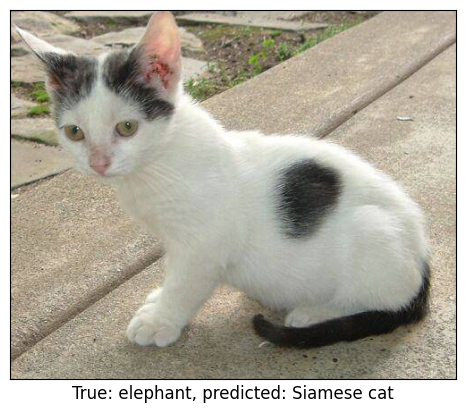

In [ ]:
# Example usage
img_path = './imgs/cat.jpg'
# img_path = './imgs/spider.jpg'
# img_path = './imgs/chicken.jpeg'
#img_path = './imgs/elephant.jpg'
img = Image.open(img_path)

# Preprocess the image
img_t = preprocess_input(img)
batch_t = torch.unsqueeze(img_t, 0).to(device)

# Get predictions
with torch.no_grad():
    out = vgg19(batch_t)

# Decode the predictions
preds = torch.nn.functional.softmax(out, dim=1)
# decoded_preds = decode_predictions(preds, top=3)
# print('Predicted:', decoded_preds)

print('Predicted:', decode_predictions(preds, top=3)[0])

plt.imshow(img)
plt.xlabel("True: elephant, predicted: {}".format(decode_predictions(preds, top=3)[0][0]), fontsize= 12)
plt.xticks([])
plt.yticks([])
plt.grid(False)

True label: Siamese cat, adversarial label: borzoi


<Figure size 640x480 with 0 Axes>

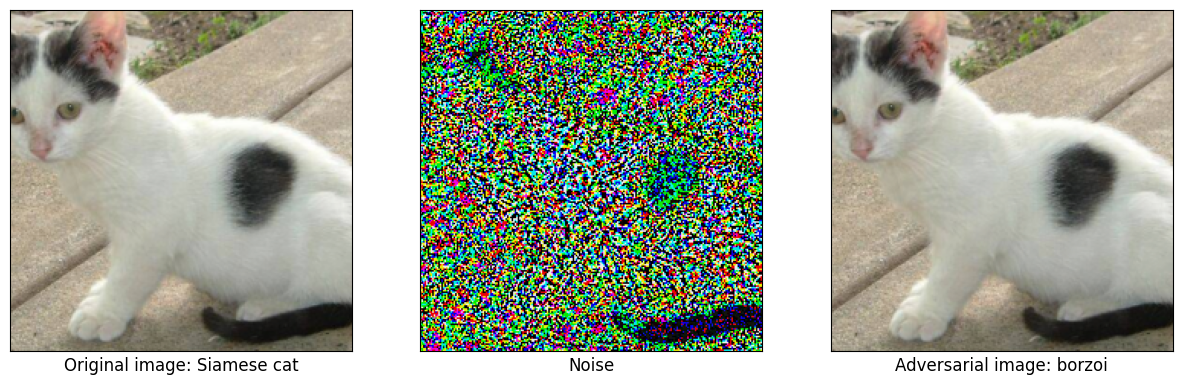

In [ ]:
# input_label = None so we use the predicted label to attack

attack_types = ['fgsm', 'trades', 'pgd']
attack_type = attack_types[2]

x_pgd = attack(attack_type, vgg19, batch_t, None, epsilon=0.01, num_steps=10, step_size=0.002, clip_value_min=-255.0, clip_value_max=255.0)


# Or directly use "pgd_attack" function
# x_pgd = pgd_attack(vgg19, batch_t, None, epsilon=0.01, num_steps=20, step_size=0.002, soft_label=True, clip_value_min=-255.0, clip_value_max=255.0, from_logits=False)

pgd_pred = vgg19(x_pgd)
true_label = decode_predictions(preds, top=3)[0][0]
adv_label = decode_predictions(pgd_pred, top=3)[0][0]
print("True label: {}, adversarial label: {}".format(true_label, adv_label))

# Convert the adversarial image and original image from PyTorch tensors to PIL images
img_pgd_pil = revert_preprocess(x_pgd.squeeze(0))
img_pil = revert_preprocess(batch_t.squeeze(0))

# Convert PIL images to numpy arrays
img_pgd = np.array(img_pgd_pil)
img = np.array(img_pil)

# Calculate noise and clip values for visualization
noise_pgd = np.clip(np.abs(img_pgd - img) * 20, 0, 255).astype('int')  # Multiply the noise by 20 for visualization


plt.clf()
# Plot the original image, noise, and adversarial image
fig = plt.figure(figsize=(15, 15 * 3))
for i in range(3):
    shown_img = img if i == 0 else noise_pgd if i == 1 else img_pgd
    shown_label = 'Original image: {}'.format(true_label) if i == 0 else 'Noise' if i == 1 else 'Adversarial image: {}'.format(adv_label)
    plt.subplot(1, 3, i + 1)

    plt.imshow(shown_img)
    plt.xlabel(shown_label, fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

As you can observe, the adversarial image looks identical to the original one from human perception. You can uncomment other statements for loading other images to see more attacks.

## <span style="color:#0b486b">III. Attack and Defence Deep Learning Models</span> ##

### <span style="color:#0b486b">III.1 AlexNet/LeNet for MNIST classification</span> ###

Below we implement AlexNet for working with MNIST dataset. Note that we apply softmax activation at the output layer, hence the model returns the logits.

In [ ]:
# Define AlexNet in PyTorch
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(96, 256, kernel_size=11, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(4096, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1000, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alex_net = AlexNet().to(device)
print(alex_net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=

Below we implement LeNet for working with MNIST dataset. Note that we do not apply softmax activation at the output layer, hence the model returns the logits.

In [ ]:
# Define LeNet in PyTorch
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 7 * 7, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
lenet = LeNet().to(device)
print(lenet)

LeNet(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=120, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)


### <span style="color:#0b486b">III.2 Create Pytorch dataset for MNIST</span> ###

In [ ]:
from torchvision import datasets, transforms, models

# Load MNIST dataset
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Plot image grid
def plot_image_grid(num_row, num_col, images, labels, image_shape):
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
    for i in range(num_row * num_col):
        ax = axes[i // num_col, i % num_col]
        ax.imshow(images[i].reshape(image_shape), cmap='gray')
        ax.set_title('Label: {}'.format(labels[i]))
        ax.axis('off')
    plt.tight_layout()
    plt.show()


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.03MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.08MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.52MB/s]


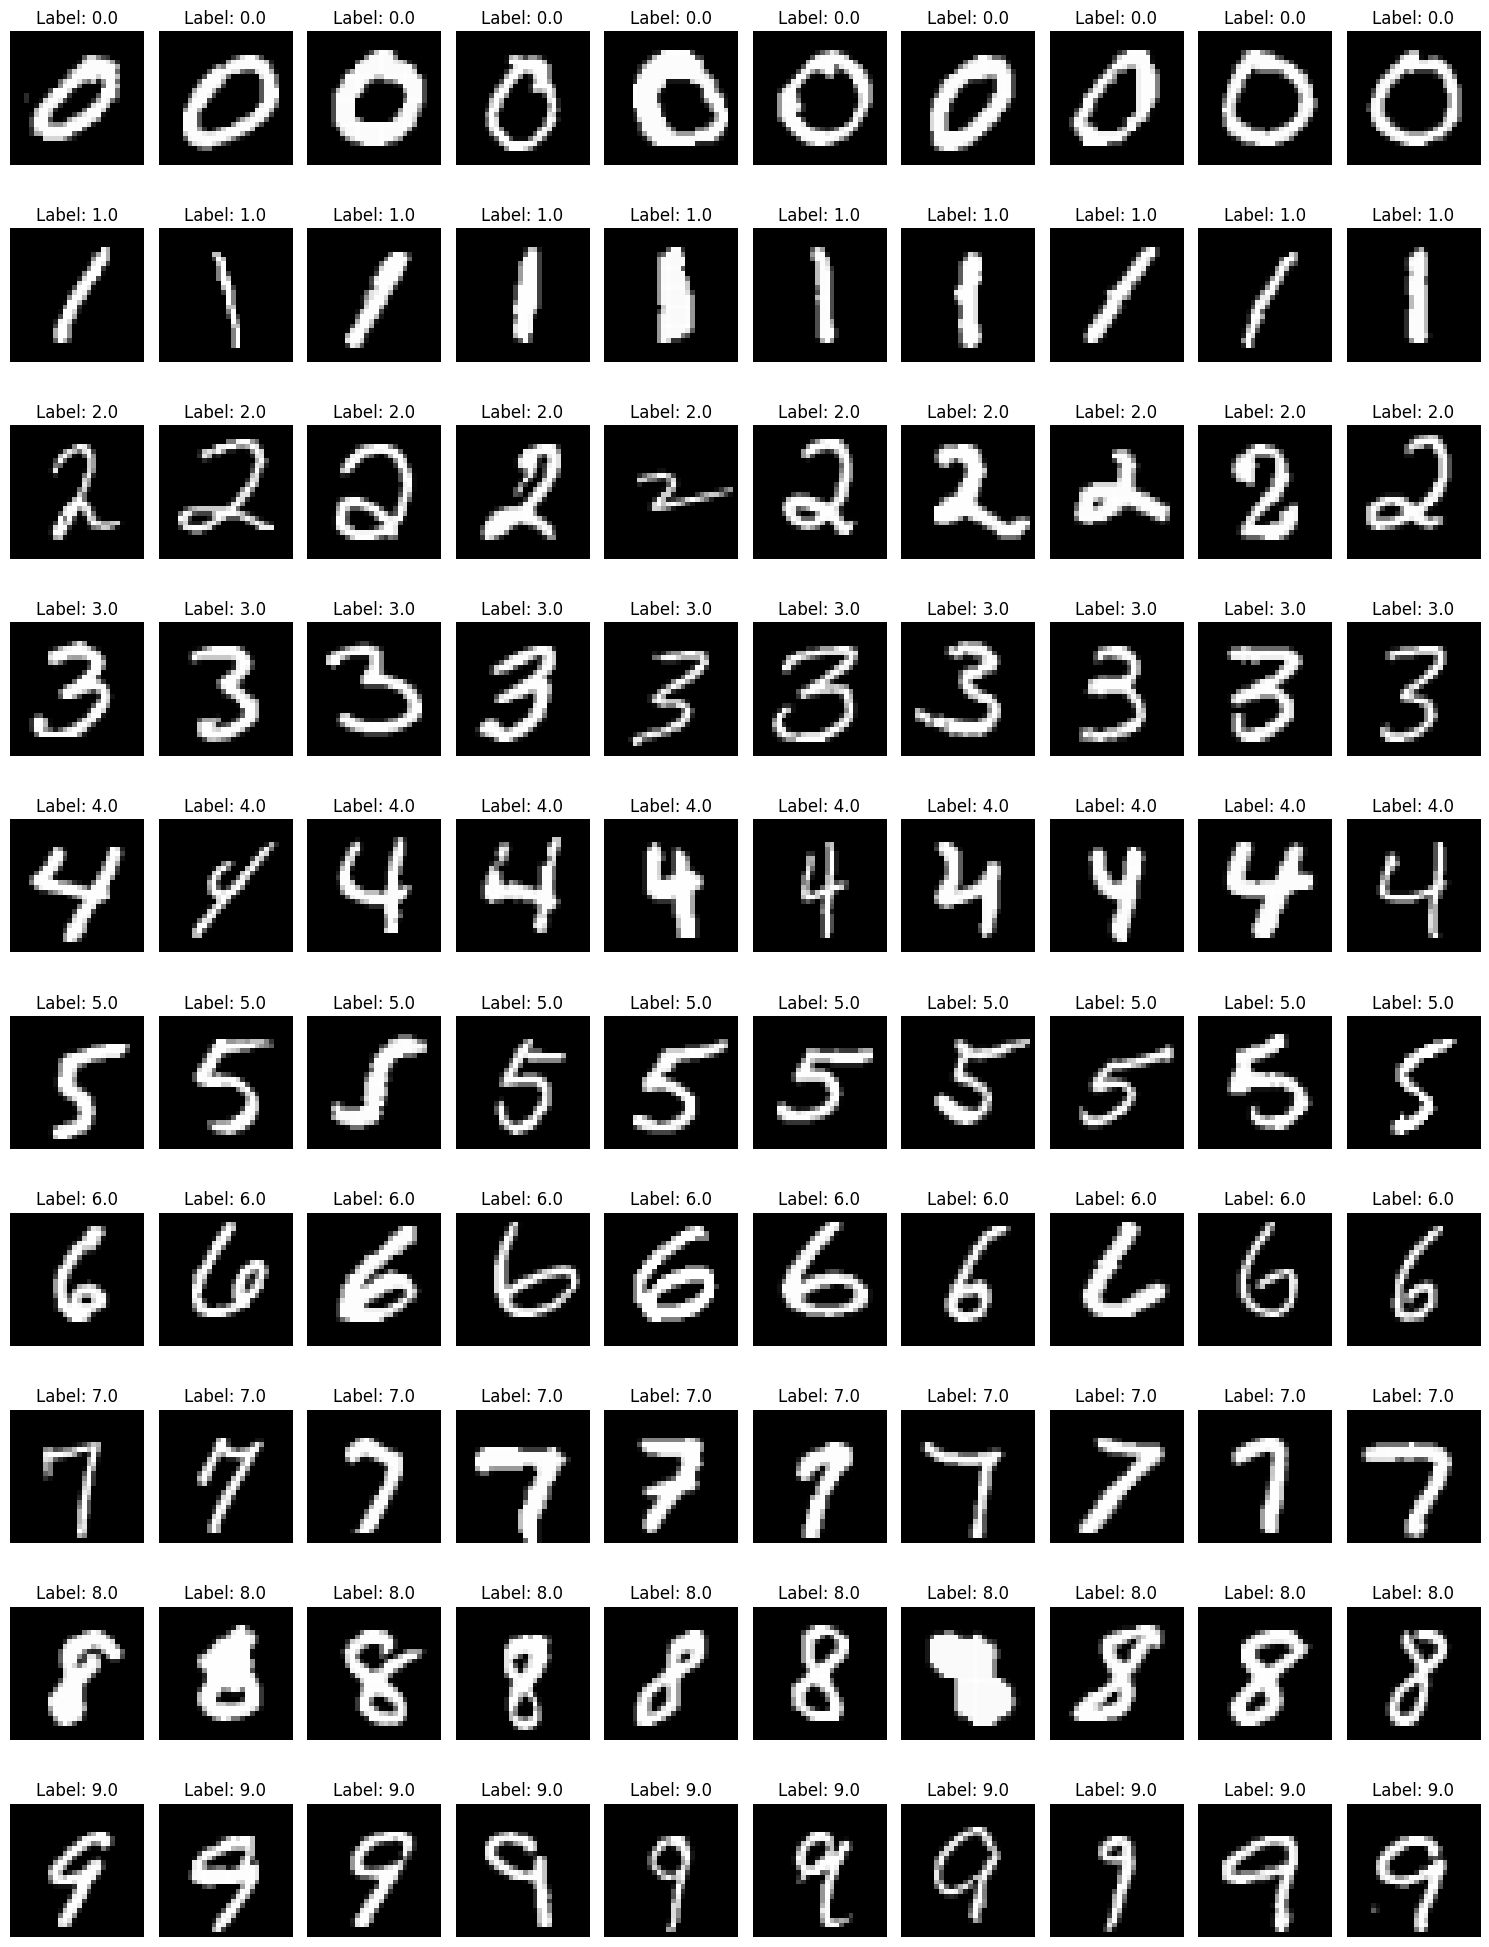

In [ ]:
# Sample data for visualization

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False)

nb_classes = 10
samples_per_class = 10
total_samples = nb_classes * samples_per_class
image_samples = np.zeros((total_samples, 28, 28, 1))
label_samples = np.zeros((total_samples,))
rng = np.random.default_rng()

for images, labels in train_loader:
    images = images.numpy()
    labels = labels.numpy()
    for i in range(nb_classes):
        indices = np.where(labels == i)[0]
        rng.shuffle(indices)
        selected_indices = indices[:samples_per_class]
        image_samples[i * samples_per_class:(i + 1) * samples_per_class, ...] = images[selected_indices].transpose(0,2,3,1)
        label_samples[i * samples_per_class:(i + 1) * samples_per_class] = i
    break

plot_image_grid(nb_classes, samples_per_class, image_samples, label_samples, (28, 28))

### <span style="color:#0b486b">III.3 Attack LeNet trained on MNIST without Adversarial Learning</span> ###

In [ ]:
from sklearn.metrics import accuracy_score

# Create Dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize model, optimizer, and loss function
lenet = LeNet().to(device)
optimizer = optim.Adam(lenet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


# Training function
def train(model, train_loader, optimizer, criterion, epochs=5):
    for epoch in range(epochs):
        total_loss = 0.0
        y_pred = []
        y_true = []
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            # Log
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            y_pred.extend(pred.squeeze().cpu().numpy())
            y_true.extend(target.cpu().numpy())

        train_loss = total_loss / len(train_loader)
        train_acc = accuracy_score(y_true, y_pred)

        print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Training Acc: {train_acc*100:.2f}%, ")

# Train the model
train(lenet, train_loader, optimizer, criterion, epochs=5)

Epoch 1, Training Loss: 0.3886, Training Acc: 87.99%, 
Epoch 2, Training Loss: 0.1145, Training Acc: 96.50%, 
Epoch 3, Training Loss: 0.0823, Training Acc: 97.47%, 
Epoch 4, Training Loss: 0.0668, Training Acc: 97.90%, 
Epoch 5, Training Loss: 0.0567, Training Acc: 98.18%, 


We run an attack with PGD.

In [ ]:
# Generate adversarial examples for the image samples
image_samples_tensor = torch.tensor(image_samples).permute(0, 3, 1, 2).float().to(device)
label_samples_tensor = torch.tensor(label_samples).long().to(device)

image_samples_adv = pgd_attack(lenet, image_samples_tensor, label_samples_tensor, epsilon=0.3,
                               num_steps=20, step_size=0.01, clip_value_min=0.0, clip_value_max=1.0)
image_samples_adv_np = image_samples_adv.permute(0, 2, 3, 1).detach().cpu().numpy()
label_sample_adv = np.argmax(lenet(image_samples_adv).detach().cpu().numpy(), axis=1)


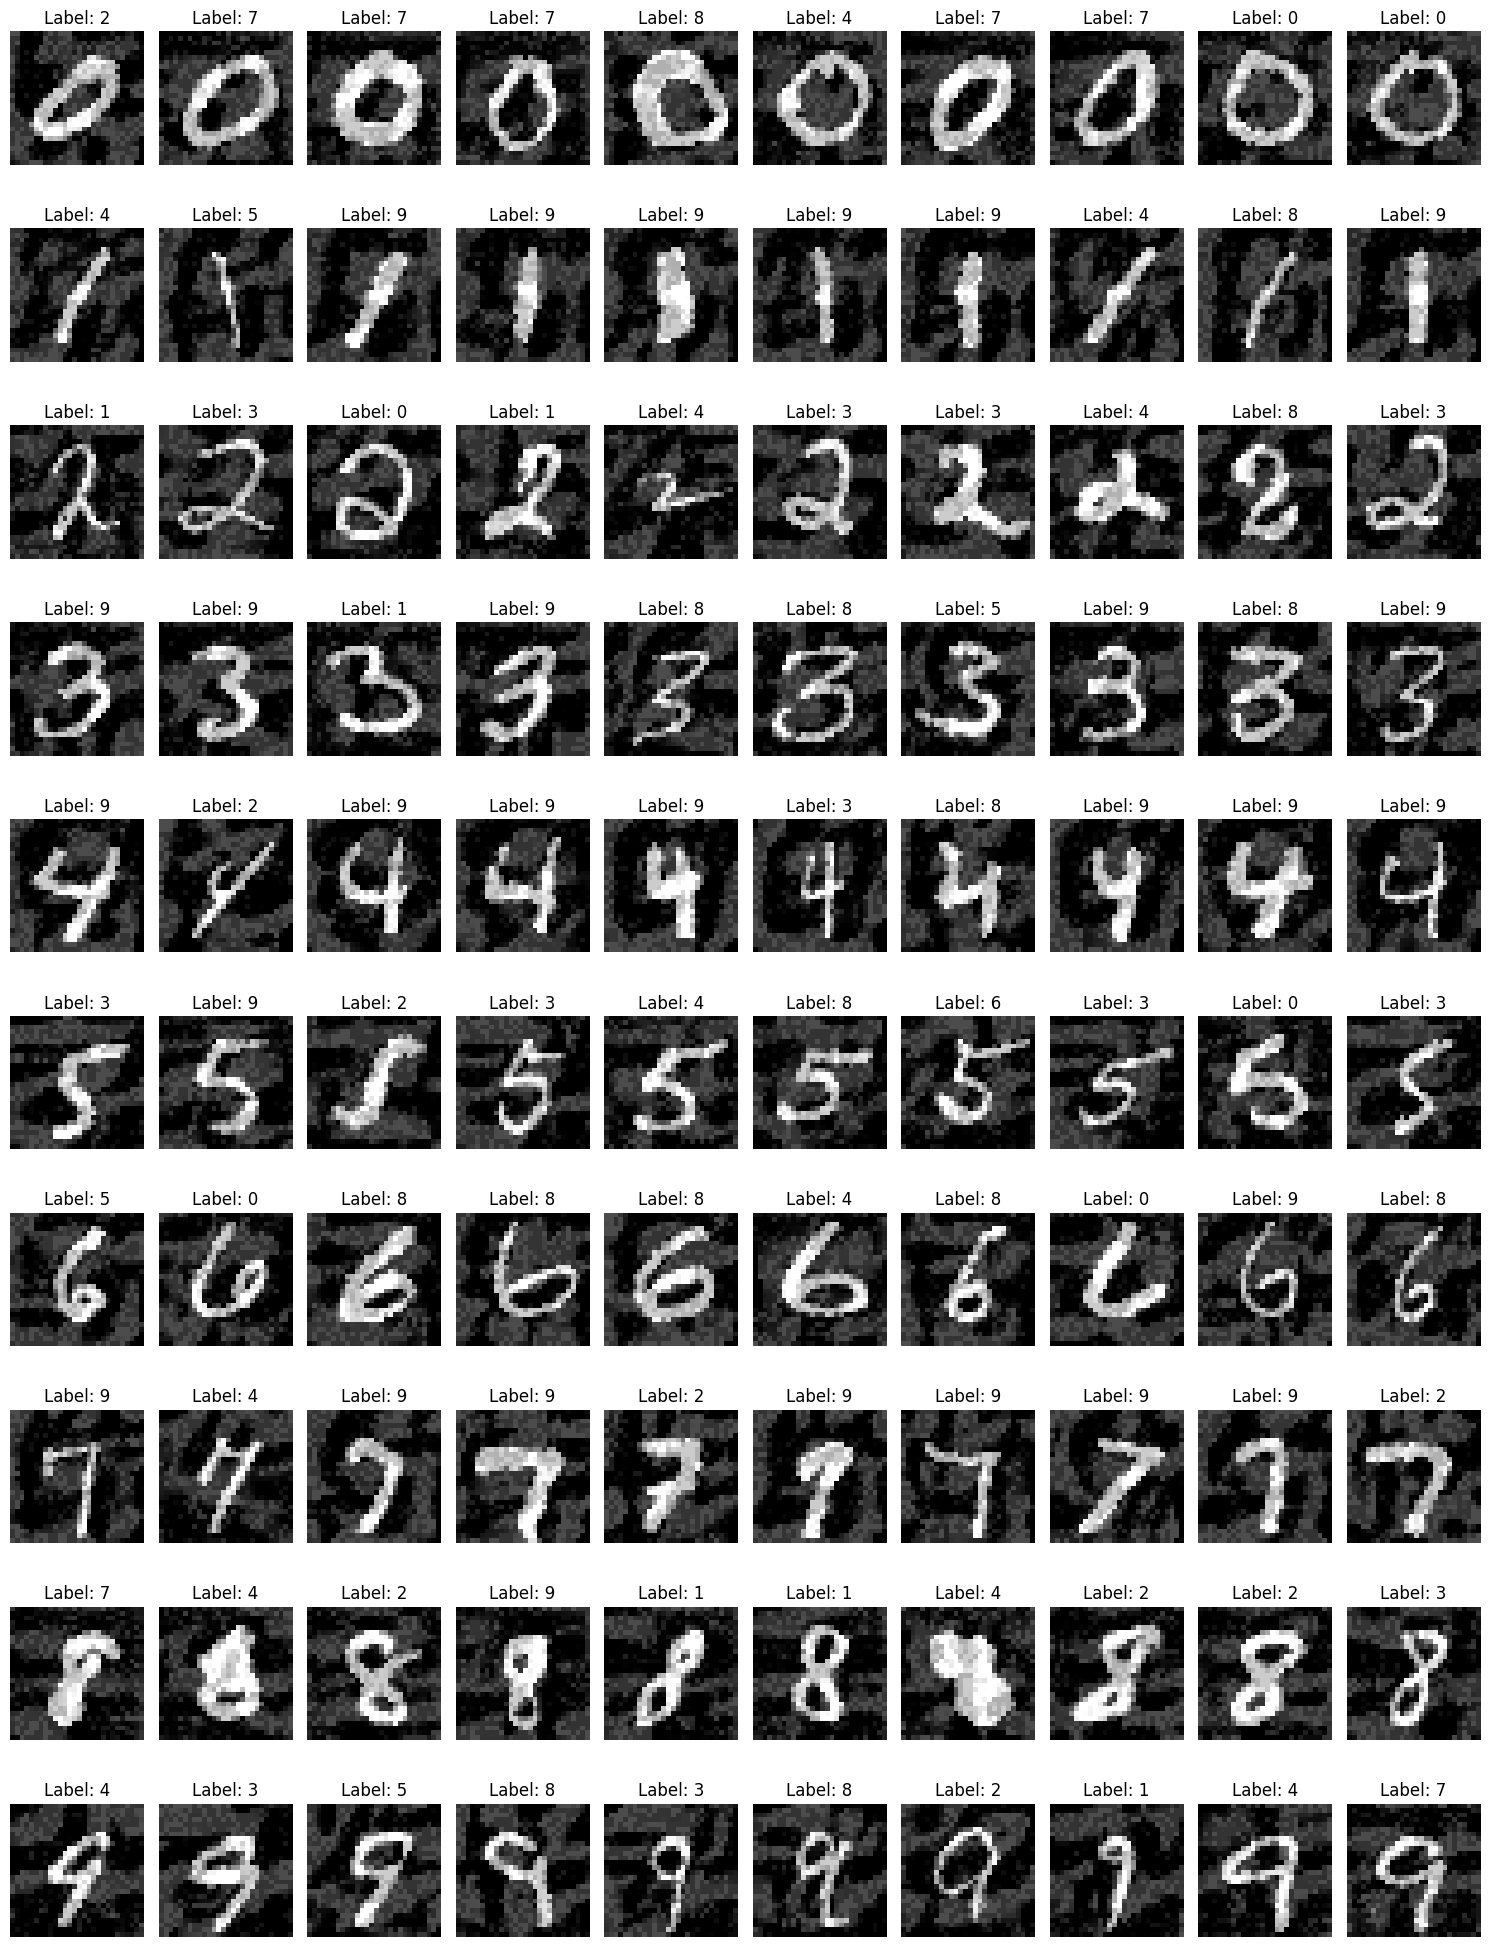

In [ ]:
# Plot the adversarial image grid
plot_image_grid(nb_classes, samples_per_class, image_samples_adv_np, label_sample_adv, (28, 28))

In [ ]:
# Evaluate adversarial accuracy on the test set

y_adv = []
y_true = []

lenet.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data_adv = pgd_attack(lenet, data, target, epsilon=0.3, num_steps=20, step_size=0.01,
                          clip_value_min=0.0, clip_value_max=1.0)
    output_adv = lenet(data_adv)
    pred_adv = output_adv.argmax(dim=1, keepdim=True)
    y_adv.extend(pred_adv.squeeze().cpu().numpy())
    y_true.extend(target.cpu().numpy())

test_adv_acc = accuracy_score(y_true, y_adv)
print("Test adversarial accuracy: {}%".format(test_adv_acc*100))

Test adversarial accuracy: 0.2%


### <span style="color:#0b486b">III.4 Attack LeNet trained on MNIST with Adversarial Learning</span> ###

In [ ]:
# Initialize model, optimizer, and loss function
lenet_defence = LeNet().to(device)
optimizer = optim.Adam(lenet_defence.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training function with adversarial examples
def train_step_adv(model, x, x_adv, y, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    logits = model(x)
    logits_adv = model(x_adv)
    loss = (criterion(logits, y) + criterion(logits_adv, y)) / 2
    loss.backward()
    optimizer.step()

    pred_adv = logits_adv.argmax(dim=1, keepdim=True)
    return loss.item(), pred_adv

# Metrics
train_loss = []
test_acc_clean = []
test_acc_pgd = []


We reinforce the defence model by adversarial examples which are generated by pgd_attack with lower capacity (e.g., num_steps=10)

In [ ]:
from sklearn.metrics import accuracy_score

# Training loop
epochs = 5
for epoch in range(epochs):
    lenet_defence.train()
    total_loss = 0.0
    y_pred = []
    y_true = []
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        x_adv = pgd_attack(lenet_defence, x, y, epsilon=0.3, num_steps=10, step_size=0.01, clip_value_min=0.0, clip_value_max=1.0)
        loss, pred_adv= train_step_adv(lenet_defence, x, x_adv, y, optimizer, criterion)

        # Log
        total_loss += loss
        y_pred.extend(pred_adv.squeeze().cpu().numpy())
        y_true.extend(y.cpu().numpy())
    train_loss = total_loss / len(train_loader)
    train_acc = accuracy_score(y_true, y_pred)

    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Training Acc: {train_acc*100:.2f}%, ")

Epoch 1, Training Loss: 0.6373, Training Acc: 70.34%, 
Epoch 2, Training Loss: 0.2313, Training Acc: 88.48%, 
Epoch 3, Training Loss: 0.1737, Training Acc: 91.18%, 
Epoch 4, Training Loss: 0.1428, Training Acc: 92.66%, 
Epoch 5, Training Loss: 0.1250, Training Acc: 93.57%, 


We then evaluate the defence model with the same pgd_attack but higher attack capacity (e.g., num_steps=20)

In [ ]:
# Evaluate adversarial accuracy on the test set
y_adv = []
y_true = []

lenet_defence.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data_adv = pgd_attack(lenet_defence, data, target, epsilon=0.3, num_steps=20, step_size=0.01, clip_value_min=0.0, clip_value_max=1.0)
    output_adv = lenet_defence(data_adv)
    pred_adv = output_adv.argmax(dim=1, keepdim=True)
    y_adv.extend(pred_adv.squeeze().cpu().numpy())
    y_true.extend(target.cpu().numpy())

test_adv_acc = accuracy_score(y_true, y_adv)
print("Test adversarial accuracy: {}%".format(test_adv_acc*100))

Test adversarial accuracy: 79.39%


In [ ]:
# Generate adversarial examples for the image samples
image_samples_tensor = torch.tensor(image_samples).permute(0, 3, 1, 2).float().to(device)
label_samples_tensor = torch.tensor(label_samples).long().to(device)

image_samples_adv = pgd_attack(lenet_defence, image_samples_tensor, label_samples_tensor, epsilon=0.3, num_steps=20, step_size=0.01,
                               clip_value_min=0.0, clip_value_max=1.0)
image_samples_adv_np = image_samples_adv.permute(0, 2, 3, 1).detach().cpu().numpy()
label_sample_adv = np.argmax(lenet_defence(image_samples_adv).detach().cpu().numpy(), axis=1)


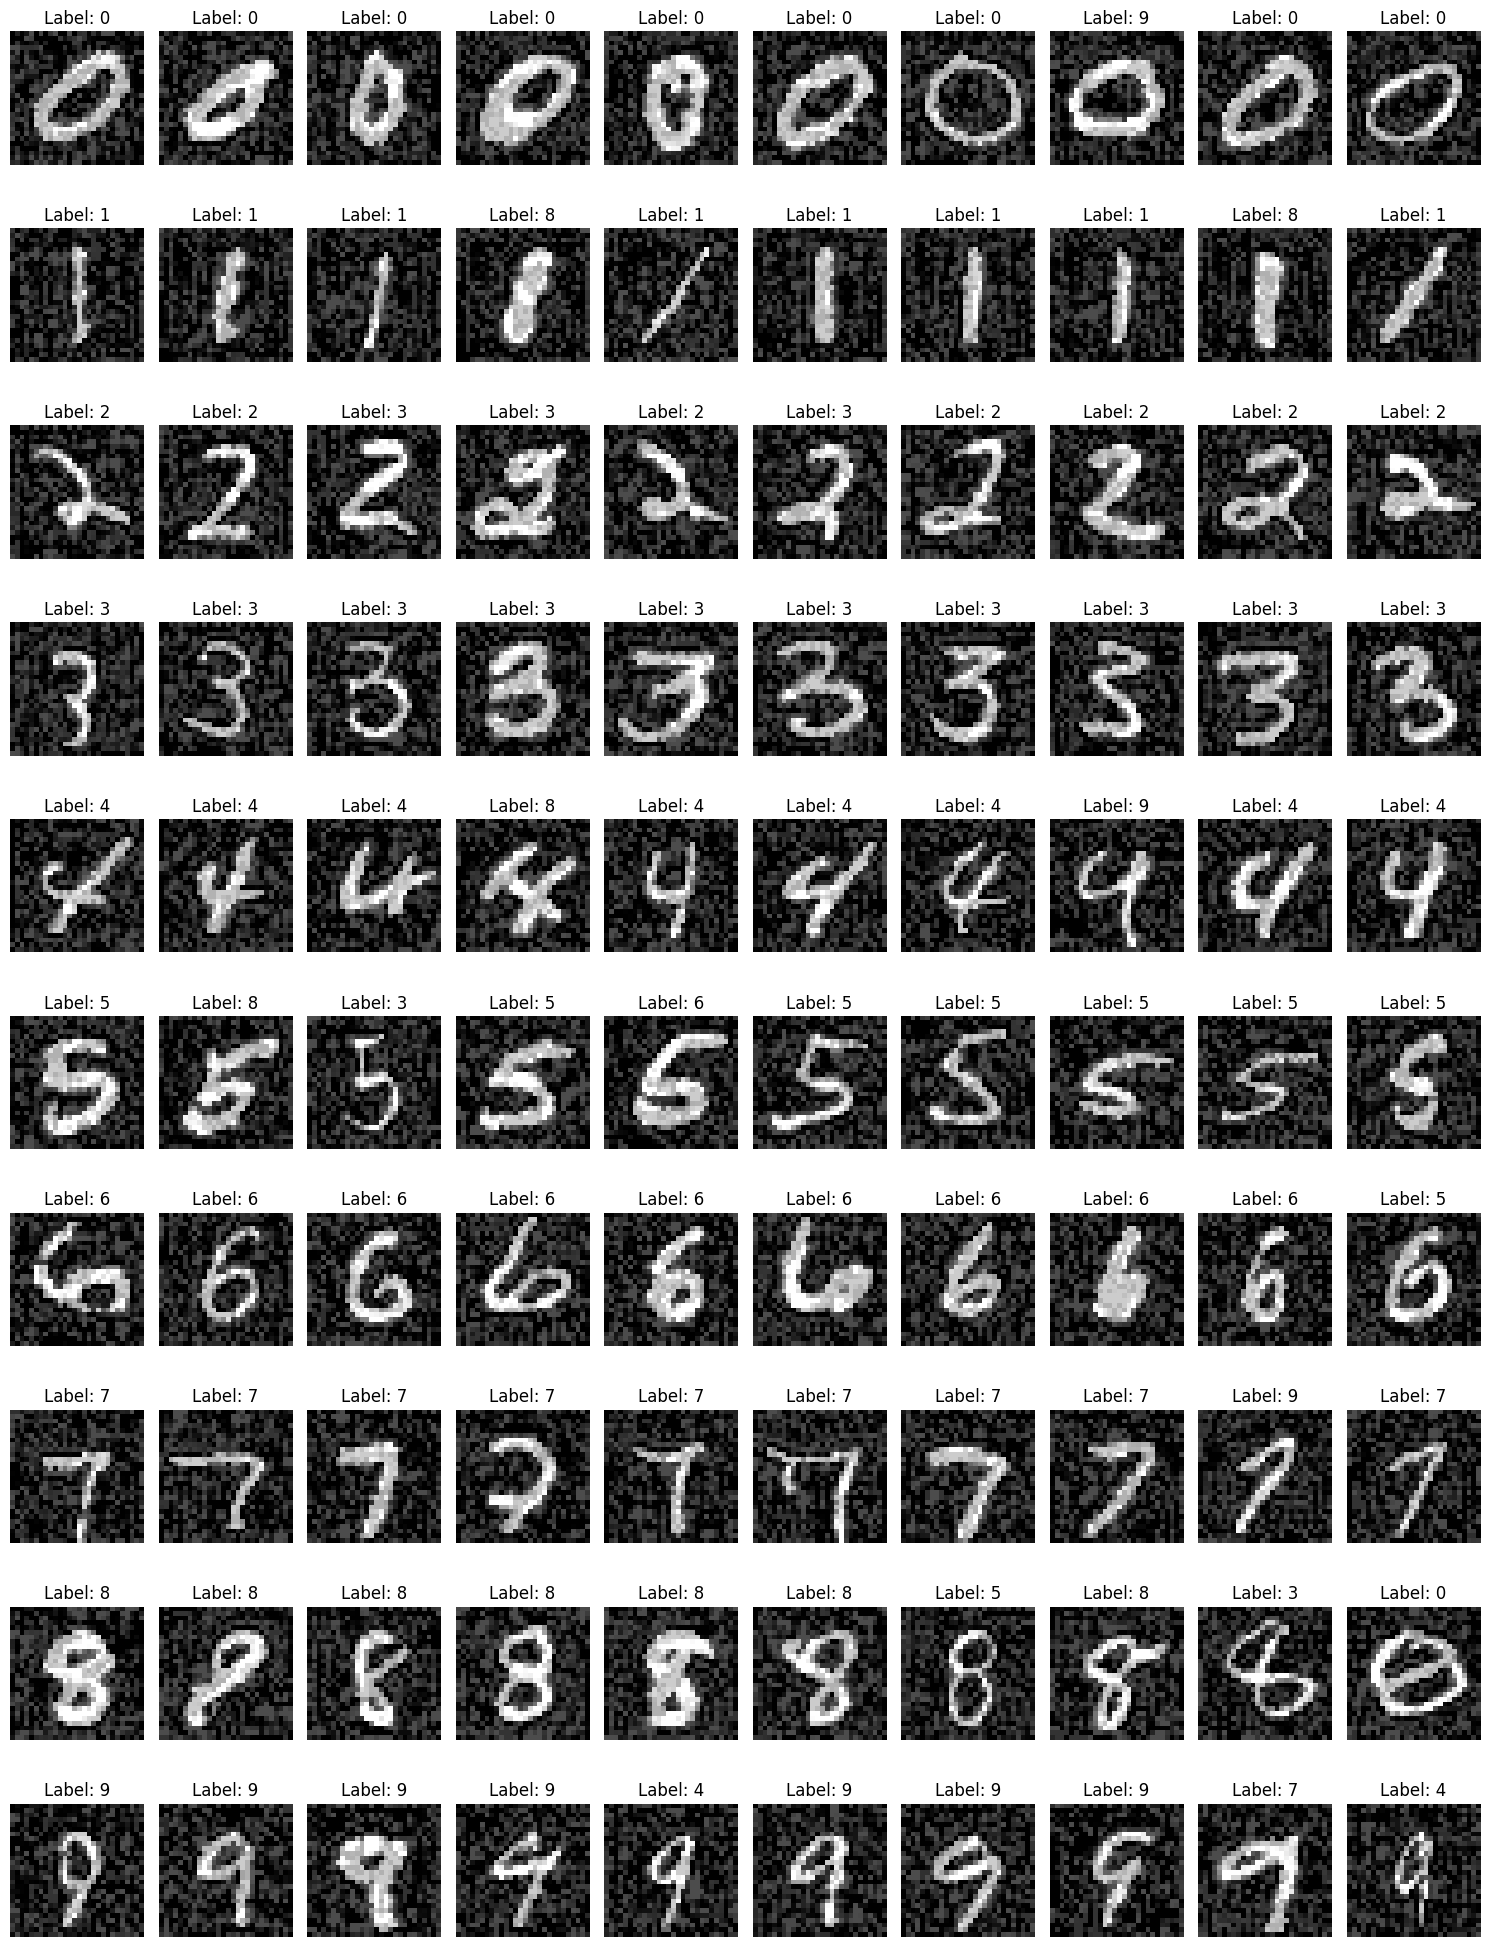

In [ ]:
# Plot the adversarial image grid
plot_image_grid(nb_classes, samples_per_class, image_samples_adv_np, label_sample_adv, (28, 28))

---
### <span style="color:#0b486b"> <div  style="text-align:center">**THE END**</div> </span>